# 02477 Bayesian Machine Learning - Exercise 1

In [34]:
%matplotlib inline
%pip install jax seaborn numpy
import pylab as plt
import jax.numpy as jnp
import seaborn as snb

from scipy.stats import binom as binom_dist
from scipy.stats import beta as beta_dist
from scipy.special import beta as beta_fun

snb.set_style('darkgrid')
snb.set(font_scale=1.5)
plt.rcParams['lines.linewidth'] = 3


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()



[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


The purpose of this exercise is to become familiar with the core components of Bayesian inference: the **prior**, the **likelihood**, **posterior** and **the model evidence**. We will also re-cap various ways to summarize distributions, e.g. **mean**, **mode**, **variance**, and **intervals**, and we will look into how to compute and manipulate probabilities using sampling. We will study these concepts in the context of the Beta-Binomial model, which is the "Hello world"-equivalent of Bayesian statistics.

One of the main applications of the Beta-Binomial model is to **estimate proportions**. For example, suppose a website shows a specific ad to $N = 112$ customers and $y = 13$ of those costumers end up clicking on the ad. A common task is then to estimate the click-rate for this ad in order to answer questions like the following:

1) What is the probability that the next customer will click on the ad?

2) What is the probability that the click-rate is below 10%?

We will see how the Bayesian Beta-Binomial model can be used to answer such questions. Furthermore, we will conclude the exercise by studying a slightly more general version of the problem: Suppose a website has two ads: version A and version B and that version A was shown $N_A$ times and generated $y_A$ clicks, whereas version B was shown $N_B$ times and generated $y_B$ click. What is the probability that the click-rate of version B is larger than click-rate of version A?

We highly encourage you to **discuss your results and conclusions with one of the teachers/teaching assistant to check you understanding**. Moreover, if you get stuck with an exercise, don't hesitate to consult the solution or the teachers/teaching assistant.

**Content**

- Part 1: Maximum likelihood estimation
- Part 2: Bayesian inference
- Part 3: The functional form of Beta distributions
- Part 4: Computing summary statistics and probabilities using sampling
- Part 5: Application to A/B testing


**Note on JaX**

In this course, we will be using the [JaX-framework](https://github.com/jax-ml/jax) for numerical computations. The module `jax.numpy` implements an interface very similar to the familiar `numpy` for basic operations, but JaX is much faster than numpy and JaX also features GPU support, automatic differentiation, just-in-time compilations, and many other advanced features. However, we won't be using the advanced features of JaX in this course. The biggest difference between `jnp.numpy` and `numpy` is how random number generation is handled, but we will get into that later.

We typically use

`import jax.numpy as jnp`

to remind ourselves that we are working JaX and not regular numpy. JaX can be installed using most environment managers, e.g. pip:

`pip install -U jax`

For more information about JaX, consult the website: [https://github.com/jax-ml/jax](https://github.com/jax-ml/jax).




## Estimating the proportions using the binomial distribution

In this exercise, we will work with two common families of probabilities distributions: the **Binomial distribution** and the **Beta distribution**. 

### The Binomial distribution and maximum likelihood estimation

First, we re-cap the ***Binomial distribution***. The Binomial distribution is a discrete probability distribution representing the number of successes in a sequence of **conditionally independent Bernoulli trials** and it is specified through its **probability mass function (PMF)**:

$$
\begin{align*}
p(y|N, \theta) &= \text{Bin}(y|N, \theta)\\
&= {N\choose y} \theta^{y}(1-\theta)^{N-y},
\end{align*}$$

where $N$ is the number of trials, $\theta \in \left[0, 1\right]$ is the probability of success in each individual trial and $y \in \left\lbrace 0, 1, \dots, N \right\rbrace$ is the total number of successes. The quantity ${N\choose y}$ is a called a binomial coefficient and is pronounced "$N$ choose $y$" and counts the number of ways $y$ items can be chosen from a set of $N$ items. The simplest way to estimate $\theta$ is through **maximum likelihood estimation (MLE)**, which for this model can be done analytically:

$$\hat{\theta}_{\text{MLE}} = \arg\max_{\theta} p(y|N, \theta) = \frac{y}{N}.$$

We can also compute a classic/frequentist 95%-**confidence interval**:

$$\hat{\theta}_{\text{MLE}} \pm 1.96 \sqrt{\frac{\hat{\theta}_{\text{MLE}}(1-\hat{\theta}_{\text{MLE}})}{N}}.$$

Technically, this type of interval is called a **Wald interval** and relies on a Gaussian approximation, but we won't cover these details in this course. Note that a **confidence interval** is **generally not** the same as a **posterior credibility interval** (see Section 4.6.6 in Murphy1). 


### The beta distribution as prior distribution for the proportion $\theta$

The ***Beta distribution*** is distribution over random variables in the unit interval. The **probability density function (PDF)** of the Beta distribution has two parameters $a_0 > 0$ and $b_0 > 0$ and is given by

$$p(\theta|a_0,b_0) = \frac{1}{B(a_0,b_0)}\theta^{a_0-1}(1-\theta)^{b_0-1},$$

where $B(a_0, b_0)$ is a **normalization constant** that ensures that the density integrates to one:

$$B(a_0,b_0) = \int \theta^{a_0-1}(1-\theta)^{b_0-1} \text{d}\theta = \frac{\Gamma(a_0)\Gamma(b_0)}{\Gamma(a_0+b_0)},$$

where $\Gamma$ is the so-called gamma function, which we won't dive deeper into in this course. Since $B(a_0,b_0)$ is a constant wrt. $\theta$, it holds that

$$p(\theta|a_0,b_0) \propto \theta^{a_0-1}(1-\theta)^{b_0-1},$$

and therefore, we say that $f(\theta) = \theta^{a-1}(1-\theta)^{b-1}$ is the **functional form** of a Beta distribution for some $a,b > 0$.

The **mean** of a Beta-distributed random variable, $\theta \sim \text{Beta}(a_0, b_0)$, is given by

$$\mathbb{E}\left[\theta\right] = \int_0^1 \theta \, p(\theta|a_0,b_0) \,\text{d} \theta  = \frac{a_0}{a_0+b_0}. \tag{1}$$

The quantity $\mathbb{E}\left[\theta\right]$ is also sometimes refered to as the **expected value** of $\theta$ or the **first moment** of $\theta$. The **variance** of $\theta$ is

$$\mathbb{V}\left[\theta\right] = \int_0^1 \left(\theta - \mathbb{E}\left[\theta\right] \right)^2 \, p(\theta|a_0,b_0) \,\text{d} \theta  = \frac{a_0 b_0}{(a_0+b_0)^2(a_0+b_0+1)}.$$

When $a_0, b_0 > 1$ the Beta density is **unimodal** with the mode (i.e. the location of the peak of the distribution) given by 

$$\theta_{\text{mode}} = \frac{a_0 - 1}{a_0 + b_0 - 2}.$$

If needed, you can find more information about both distributions in Section 2.4.1 (Murphy1) in the textbook or on Wikipedia: 

[https://en.wikipedia.org/wiki/Beta_distribution](https://en.wikipedia.org/wiki/Beta_distribution)

[https://en.wikipedia.org/wiki/Binomial_distribution](https://en.wikipedia.org/wiki/Binomial_distribution)

### The Beta-binomial model ###


The beta-binomial model is a Bayesian model for estimating proportions $\theta \in \left[0, 1\right]$, where the **likelihood** is the binomial distribution and a Beta distribution is used as a **prior distribution** for the parameter $\theta$. The key equations for the model are given by

\begin{align*}
    p(\theta) &= \text{Beta}(\theta|a_0, b_0)&&\text{(Prior)}\\
    p(y|\theta) &= {N \choose y} \theta^y (1-\theta)^{N-y}&&\text{(Likelihood)}\\
    p(\theta|y) &= \text{Beta}(\theta|a_0 + y, b_0 + N-y)&&\text{(Posterior)}
  \end{align*}


for the dataset $\mathcal{D} = \left\lbrace N, y \right\rbrace$. 

**Notation**

Following the convention of the book, we will the use both $p(\theta|y)$ and $p(\theta|\mathcal{D})$ to denote the posterior distribution of $\theta$ conditioned on $y$. We will often write $p(\theta)$ to denote the prior instead of $p(\theta|a_0,b_0)$ and usually only use  the latter if we want to highlight the dependency on the hyperparameters $a_0, b_0$. 

We will typically refer to $\theta$ as the **parameter** of the model and to $a_0, b_0$ as **hyperparamters** of the model.
 

# Part 1:  Maximum likelihood estimation
Assume you want to estimate the probability of success, $\theta \in \left[0, 1\right]$, after observing $y = 1$ success out of $N = 7$ independent Bernoulli trials. That is, your dataset is given by $\mathcal{D} = \left\lbrace N = 7, y = 1\right\rbrace$.

**Task 1.1**: Plot the likelihood $p(y|\theta)$ as a function of $\theta$ for $\theta \in \left[0,1\right]$ and identify the maximum likelihood solution visually/numerically. 

*Hints:*

- *You can either implement the likelihood function yourself using the equation given above, or you can use the implementation from scipy.stats: binom_dist.pmf(y, n, p), where y is the number of success, n is the number of trials and p is the probability of success.*
- *If you don't know how to get started, study the solution.*



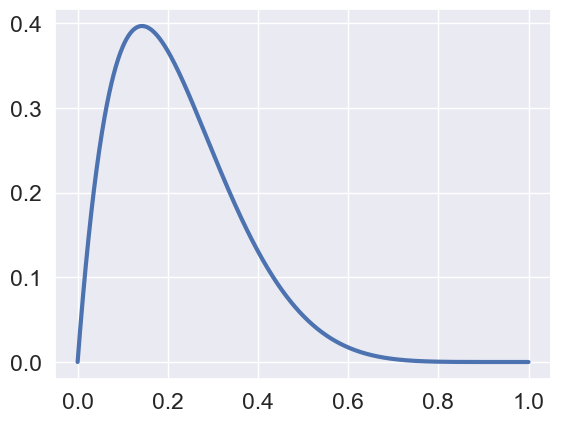

Array([-0.11637248,  0.4020868 ], dtype=float32, weak_type=True)

In [35]:
# data
N1 = 7
y1 = 1

# make grid for plotting the likelihood p(y|theta) in interval [0, 1]
thetas = jnp.linspace(0, 1, 1000)

binom_dist_ = lambda y1, N1, thetas: thetas**y1 * (1 - thetas)**(N1 - y1)

plt.plot(thetas, binom_dist.pmf(y1, N1, thetas), label='Likelihood') 
# plt.plot(thetas, binom_dist_(y1, N1, thetas), label='Likelihood') 
plt.show()


# Confidence interval
theta_MLE = y1 / N1

theta_MLE + jnp.array([-1, 1]) * 1.96 * jnp.sqrt(theta_MLE * (1 - theta_MLE) / N1)



**Task 1.2**: Compute the maximum likelihood estimate for $\theta$ and compute a 95% confidence interval using the equations given above.

answer: $\hat{\theta}_{\text{MLE}} = 1/7$ and the 95% confidence interval is $[-0.11637248,  0.4020868 ]$.


**Task 1.3**: What happens if you had observed $y = 0$ instead of $y = 1$? Does the result seem reasonable?

***Note**: *This is a discussion question, which means that you actively have to experiment with the code and/or reason with the equations to arrive at the relevant conclusions. This also means that we won't provide a specific solution for this task. However, you are more than welcome to check your understanding and your conclusions with the TAs.**

answer: No it does not seem reasonable since the MLE estiamte is 0, which we know to overfitting.

# Part 2:  Bayesian inference

We will now turn our attention towards Bayesian inference for $\theta$. Recall, the core concept of Bayesian inference is that we infer a **full probability distribution**  for $\theta$ rather than just a **point estimate** like $\hat{\theta}_{MLE}$. 
As before, your dataset is given by $\mathcal{D} = \left\lbrace N = 7, y = 1\right\rbrace$, but now we assume a **uniform prior distribution** for $\theta$, i.e. $p(\theta) = \text{Beta}(\theta|a_0,b_0) = 1$ for $a_0 = b_0 = 1$.

**Task 2.1**: Compute the **prior** mean and variance of $\theta$, i.e. the mean and variance of $p(\theta)$.




In [112]:
N = 7
y = 1
a0 = b0 = 1

# prior mean
E = a0 / (a0 + b0)

# prior variance
V = (a0*b0)/((a0+b0)**2 * (a0 + b0 + 1))

E, V

(0.5, 0.08333333333333333)



**Task 2.2**: Compute the parameters $a$ and $b$ of the posterior distribution, i.e. $p(\theta|y)$, using the equations for the Beta-binomial model.






In [113]:
# posterior
a1 = a0 + y
b1 = b0 + N - y

a1, b1

(2, 7)

**Task 2.3**: Plot the prior density $p(\theta)$, likelihood $p(y|\theta)$, and the posterior density $p(\theta|y)$ as a function of $\theta$ for $\theta \in \left[0, 1\right]$ in the same figure.

*Hints: the functions beta_dist.pdf and binom_dist.pmf might come in handy*




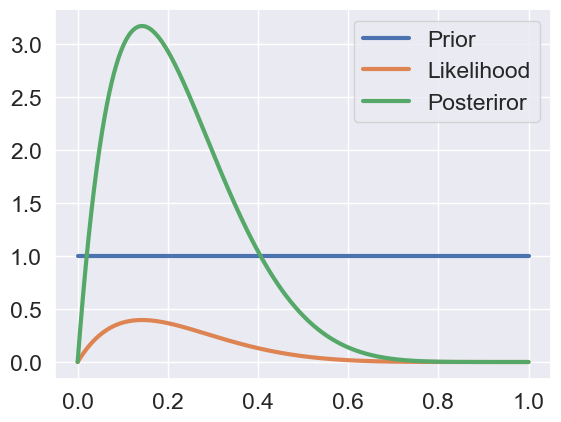

In [114]:

plt.plot(thetas, beta_dist.pdf(thetas, a0, b0), label='Prior')
plt.plot(thetas, binom_dist.pmf(y, N, thetas), label='Likelihood')
plt.plot(thetas, beta_dist.pdf(thetas, a1, b1), label='Posteriror')
plt.legend()
plt.show()

**Task 2.4**: Compute the **MAP-estimator** for $\theta$ as well as the posterior mean of $\theta$. 

*Hint*: *The MAP-estimator is the mode of the posterior density, i.e. $\theta_{\text{MAP}} = \arg\max\limits_{\theta \in \left[0, 1\right]} p(\theta|y)$*, and can be computed analytically for the Beta-binomoial model.



**Task 2.5**: Compute a 50%, 90% and a 95% posterior credibility interval for $\theta$.

*Hints*:
-  To obtain a 50% posterior credibility interval, our goal is to identify $\theta_1, \theta_2 \in \left[0, 1\right]$ such that  $p(\theta \in \left[\theta_1, \theta_2\right]|\mathcal{D}) = \int _{\theta_1}^{\theta_2} p(\theta|\mathcal{D}) \text{d} \theta  \approx 0.5$
- *scipy.stats.beta.interval* might come in handy for this.




In [105]:
# MAP estimator
theta_MAP = (a1 - 1) / (a1 + b1 - 2)
print(theta_MAP)

# posteriror mean
theta_post_mean = a1 / (a1 + b1)
print(theta_post_mean)

# credible interval using scipy.stats.beta.interval
print(beta_dist.interval(0.50, a1, b1))
print(beta_dist.interval(0.90, a1, b1))
print(beta_dist.interval(0.95, a1, b1))

0.14285714285714285
0.2222222222222222
(np.float64(0.1206287410983218), np.float64(0.30269973357416047))
(np.float64(0.04638926397961112), np.float64(0.47067940860113155))
(np.float64(0.031854026249944246), np.float64(0.5265096708752065))


**Task 2.6**: What happens if you had observed $y = 0$ instead of $y = 1$? Does the result seem reasonable?

**Note**: *This is a discussion question, which means that you actively have to experiment with the code and/or reason with the equations to arrive at the relevant conclusions. This also means that we won't provide a specific solution for this task. However, you are more than welcome to check your understanding and your conclusions with the TAs.*


answer: even if the posterior MAP-estimator becomes 0 with y=0, the posterior mean is still above 0, at 0.1 recurring, which is also a reasonable estimate.

**Task 2.7**: Experiment with different values of $a_0$, $b_0$, $N$, and $y$ to explore how it affects the results (e.g. the plots, MAP, posterior mean and posterior credibility interval).

**Note**: *This is a discussion question, which means that you actively have to experiment with the code and/or reason with the equations to arrive at the relevant conclusions. This also means that we won't provide a specific solution for this task. However, you are more than welcome to check your understanding and your conclusions with the TAs.*




In the next few tasks, we will explore the relationships between the posterior mean and the maximum likelihood estimator.

**Task 2.8** Show that the posterior mean converges to the maximum likelihood estimator $\hat{\theta}_{\text{MLE}} = \frac{y}{N}$ as $N \rightarrow \infty$.

*Hints:*
- *Write the posterior mean as a function of $a_0, b_0, N, y$*
- *Write the number of successes as $y = \hat{\theta}_{MLE} N$ and substitute it into the expression for the posterior mean*
- *If you are stuck, don't hesitate to consult the solution or ask the teachers/teaching assistant for an additional hint*





**Task 2.9** Show that the posterior mean is always between the prior mean, $\theta_0 = \frac{a_0}{a_0 + b_0}$, and the maximum likelihood estimate $\hat{\theta}_{MLE} = \frac{y}{N}$.

Hints:
- Show that the posterior mean is a convex combination of the prior mean $\theta_0$ and the maximum likelihood solution $\hat{\theta}_{\text{MLE}}$, i.e. that the posterior mean can be written as 

$$
\begin{align*}
\mathbb{E}\left[\theta|\mathcal{D}\right] = (1-\lambda) \theta_0 + \lambda \hat{\theta}_{MLE}
\end{align*}
$$
for some $0 \leq \lambda \leq 1$.





# Part 3:  The functional form of Beta distributions

Suppose you are given the expression for a probability density function $p_d(\theta)$ up to a constant, i.e. you are told that $p_d(\theta) =   \frac{1}{Z_d}\theta^{36}(1-\theta)^{41}$, where $Z_d > 0$ is an unknown, but positive constant.


**Task 3.1**: Argue the distribution $p_d$ specified above must be a Beta-distribution $p(\theta|a_d, b_d)$ and identify its parameters $a_d, b_d$.






**Task 3.2**: Compute $Z_d$

*Hint: What is the normalization constant for a Beta distribution?*




We will now use our knowledge of the functional form for Beta densities to compute the denominator in Bayes' theorem, $p(y)$, which is often called the **model evidence** or the **marginal likelihood**. It can be expressed using the **product rule** and the **sum rule** of probability theory:

$$\begin{align*}
p(y) = \underbrace{\int p(y, \theta) \text{d}\theta}_{\text{sum rule}} = \int \underbrace{p(y|\theta)p(\theta)}_{\text{product rule}} \text{d}\theta .
\end{align*}
$$

Later in the course, we will see that this term can be useful for hyperparameter tuning and model selection. For most models of practical interest, the term will be **intractable** because we cannot solve the integral above analytically.  However, for models like the beta-binomial we actually compute this term in closed-form.

**Task 3.3**: Compute the analytical expression for the  model evidence for the Beta-Binomial model

**Hints**:
- Insert the probability mass function for the binomial likelihood and the probability density function for the beta distribution in the integral given above.
- Use linearity of integrals to "move" constants (wrt. $\theta$) outside the integral
- Identify the resulting integral as the integral of the functional form corresponding to a Beta density.



# Part 4:  Computing summary statistics and probabilities using sampling

Once, we have obtained our posterior distribution of interest, we often compute the relevant **summary statistics** using **sampling** when the quantities can not easily be computed analytically. We can often generate a set of samples to represent the distribution and then compute the quantities of interest based on the samples. For example,



In [ ]:
# specify parameters for posterior distribution
a = 6
b = 17

# generate samples
num_samples = 100000
theta_samples = beta_dist.rvs(a=a, b=b, size=num_samples)

# plot
thetas = jnp.linspace(0, 1, 200)
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
ax.plot(thetas, beta_dist.pdf(thetas, a=a, b=b), label='$p(\\theta|y)$')
ax.hist(theta_samples, 50, density=True, label='Histogram of posterior samples of $\\theta$', alpha=0.5, color='g')
ax.set(xlabel='$\\theta$')
ax.legend();

Using the posterior samples $\theta^{(i)} \sim p(\theta|y)$ for $i = 1, \dots, S$, we can easily **estimate** the posterior mean and variance:

In [ ]:
analytical_posterior_mean = a/(a+b)
analytical_posterior_variance = (a*b)/((a+b)**2*(a+b+1))

print(f'E[theta|D] = {jnp.mean(theta_samples):5.4f} (estimated using samples)')
print(f'E[theta|D] = {analytical_posterior_mean:5.4f} (analytical solution)\n')
print(f'V[theta|D] = {jnp.var(theta_samples):5.4f} (estimated using samples)')
print(f'V[theta|D] = {analytical_posterior_variance:5.4f} (analytical solution)')

Sampling is often easy to implement, and hence, it can also be a highly valuable method for verifying analytical results. 

We can also estimate probabilities and credibility intervals using samples as follows. Suppose we want to estimate the posterior probability that $\theta > 0.2$, then we generate $S$ samples from the posterior, i.e. $\theta^{(i)} \sim p(\theta|\mathcal{D})$ for $i = 1, ..., S$, and then simply count the fraction of samples satisfying $\theta^{(i)} < 0.2$. The reason this works is that we can phrase  the probability as an expectation value, which can be estimated using so-called **Monte Carlo samples**:

$$\begin{align*}
P(\theta > 0.2 | \mathcal{D}) = \int_{0.2}^1 p(\theta|\mathcal{D}) \text{d} \theta = \int_0^1 \mathbb{I}\left[\theta > 0.2\right] p(\theta|\mathcal{D}) \text{d}\theta = \mathbb{E}_{p(\theta|\mathcal{D})}\left[\mathbb{I}\left[\theta > 0.2\right]\right] \approx \frac{1}{S}\sum_{i=1}^S \mathbb{I}\left[\theta^{(i)} > 0.2\right],
\end{align*}$$
where $\mathbb{I}\left[\cdot\right]$ is the indicator function yielding $1$ if the condition in the brackets are true, and 0 otherwise. We will talk much more about Monte Carlo sampling later in the course, but for now, we will simply use it as tool to summarize distributions:

In [ ]:
print(f'P[theta > 0.2|D] = {jnp.mean(theta_samples > 0.2):5.4f}\t\t\t(estimated using sampling)\n')

interval = jnp.percentile(theta_samples, jnp.array([2.5, 97.5]))
print(f'95% credibility interval: [{interval[0]:4.3f}, {interval[1]:4.3f}]\t(estimated using sampling)')

Generally, the larger number of samples $S$ used, the more accurate an estimate we will get. Later in the course, we will make this statement much more precise.

**Example**

A friend of yours is building a classifier for a company, and she asks for your help to evaluate the model. On an independent test set of $N = 100$ examples, the classifier made $y = 8$ errors.  It is critical for the company that the error rate is below 10%. Your friend argues that the error rate is $\frac{8}{100} = 0.08$, so there no need to worry, but you are not as convinced because of the rather small test set.

Let $\theta$ represent the error rate and assume a flat Beta-prior, i.e. $a_0 = b_0 = 1$. 

**Task 4.1**: Compute the posterior mean of the error rate $\theta$.






**Task 4.2**: Generate $S = 10000$ samples from the posterior distribution and estimate the posterior probability of the test error being larger than $10%$.  Comment on the result.




# Part 5:  Application to A/B testing



Suppose a website has two ads: version A and version B and that version A was shown $N_A = 947$ times and generated $y_A = 87$ clicks, whereas version B was shown $N_B = 1053$ times and generated $y_B = 101$ click.

We will now put everything together and apply it do a Bayesian analysis of the data using the Beta-binomial model. 

**Task 5.1** Assuming a $\text{Beta}(\theta|2, 2)$ prior for both $\theta_A$ and $\theta_B$, plot the posterior density for both ads.



**Task 5.2** Estimate the mean and a 95%-credibility interval for both ads. Use a $p(\theta) = \text{Beta}(\theta|2, 2)$ prior for both ads.




**Task 5.3** Generate $S = 10000$ posterior samples for both ads and plot the histograms of both sets of samples.




**Task 5.4** Compute posterior samples for the difference of $\theta_D = \theta_B - \theta_A$ and visualize the histogram





**Task 5.5** Compute the posterior mean and 95% credibility interval for $\theta_D$ using the posterior samples



**Task 5.6** What is the posterior probability that the click-rate of version B is larger than click-rate of version A?

